<a href="https://colab.research.google.com/github/varsha6319/Accident-detector/blob/master/tasks/computer-vision/image-classification/Image_Classification(VGG16).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
import zipfile
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
!pip install -U -q PyDrive
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
import mlflow
from keras.preprocessing.image import img_to_array, array_to_img
import numpy as np 
import os, time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras import models
from keras.models import Model
from keras import layers
from keras import optimizers
from keras import callbacks
from keras.layers.advanced_activations import LeakyReLU
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16;
from keras.applications.vgg16 import preprocess_input
import os
from sklearn.metrics import classification_report
import pickle


from oauth2client.client import GoogleCredentials# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#integrating mlflow
import mlflow.keras
mlflow.keras.autolog()

In [0]:
link = 'https://drive.google.com/open?id=16yQzO4taugzRH3BIKmwvSDcR_lZlRS_N'
fluff, id = link.split('=')
print (id)


downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train.csv') 
!unzip -q "/content/drive/My Drive/train.zip"
df = pd.read_csv("train.csv",encoding='utf-8')

In [0]:
link = 'https://drive.google.com/open?id=1_6KNs90tWw9vLRAWnhKzCxeFjxHaFoj8'
fluff, id = link.split('=')
print (id)
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('test.csv') 
!unzip -q "/content/drive/My Drive/test.zip"
df1 = pd.read_csv("test.csv",encoding='utf-8')

In [76]:
print(df.shape)
print(df1.shape)

(58161, 785)
(10000, 785)


In [0]:
df.shape 
df1.shape 
train_X= np.array(df.iloc[:,1:])
test_X= np.array(df1.iloc[:,1:])
train_Y= np.array (df.iloc[:,0]) 
test_Y = np.array(df1.iloc[:,0])

In [78]:
train_X.shape, test_X.shape

((58161, 784), (10000, 784))

In [79]:
classes = np.unique(train_Y)
num_classes = len(classes)
num_classes

10

In [80]:
# Images are converted into 3 channels and reshape them
train_X=np.dstack([train_X] * 3)
test_X=np.dstack([test_X]*3)

train_X = train_X.reshape(-1, 28,28,3)
test_X= test_X.reshape (-1,28,28,3)
train_X.shape,test_X.shape

((58161, 28, 28, 3), (10000, 28, 28, 3))

In [0]:
# Images are resized to 48*48 for VGG16 model
train_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in train_X])
test_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in test_X])


In [0]:
# data normalization and data type is changed
train_X = train_X / 255.
test_X = test_X / 255.
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')

In [0]:
# Labels are converted to one hot encoded format, train data is split into train and validation data 
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)
train_X,valid_X,train_label,valid_label = train_test_split(train_X,train_Y_one_hot,test_size=0.2,random_state=13)


In [84]:
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((46528, 48, 48, 3), (11633, 48, 48, 3), (46528, 10), (11633, 10))

In [0]:
#Paramters for VGG16 model
Image_Width=48
Image_Height=48
Image_Depth=3
Batch_Size=16

In [0]:
# Input is preprocessed 
train_X = preprocess_input(train_X)
valid_X = preprocess_input(valid_X)
test_X  = preprocess_input (test_X)

In [87]:
#  Create base model of VGG16
conv_base = VGG16(weights='/content/drive/My Drive/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',include_top=False,input_shape=(Image_Height, Image_Width, Image_Depth))
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

In [88]:
# Extracting features
train_features = conv_base.predict(np.array(train_X), batch_size=Batch_Size, verbose=1)
test_features = conv_base.predict(np.array(test_X), batch_size=Batch_Size, verbose=1)
val_features = conv_base.predict(np.array(valid_X), batch_size=Batch_Size, verbose=1)

11633/11633 [==============================] - 281s 24ms/step


In [0]:
# Saving the features so that they can be used for future
np.savez("train_features", train_features, train_label)
np.savez("test_features", test_features, test_Y)
np.savez("val_features", val_features, valid_label)

In [90]:
# Current shape of features
print(train_features.shape, "\n",  test_features.shape, "\n", val_features.shape)

(46528, 1, 1, 512) 
 (10000, 1, 1, 512) 
 (11633, 1, 1, 512)


In [0]:
# Flatten extracted features
train_features_flat = np.reshape(train_features, (46528, 1*1*512))
test_features_flat = np.reshape(test_features, (10000, 1*1*512))
val_features_flat = np.reshape(val_features, (11633, 1*1*512))

In [0]:
# Densely connected classifier followed by leakyrelu layer and finally dense layer for the number of classes
NB_TRAIN_SAMPLES = train_features_flat.shape[0]
NB_VALIDATION_SAMPLES = val_features_flat.shape[0]
NB_EPOCHS = 100

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=(1*1*512)))
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Dense(num_classes, activation='softmax'))

In [0]:
# Model Compilation
model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(), metrics=['acc'])

In [0]:
# reduced learning and the early stopping for callback methos
reduce_learning = callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=2,verbose=1,mode='auto',epsilon=0.0001,cooldown=2,min_lr=0)

eary_stopping = callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=7,verbose=1,mode='auto')

callbacks = [reduce_learning, eary_stopping]

In [95]:
# Model Training
history = model.fit(train_features_flat,train_label,epochs=NB_EPOCHS,validation_data=(val_features_flat, valid_label),callbacks=callbacks)

Train on 46528 samples, validate on 11633 samples
Epoch 1/100
46528/46528 [==============================] - 10s 225us/step - loss: 4.1666 - acc: 0.4288 - val_loss: 4.0469 - val_acc: 0.4680
Epoch 2/100
46528/46528 [==============================] - 10s 213us/step - loss: 3.9523 - acc: 0.5058 - val_loss: 3.9575 - val_acc: 0.4826
Epoch 3/100
46528/46528 [==============================] - 10s 212us/step - loss: 2.0813 - acc: 0.5668 - val_loss: 1.0486 - val_acc: 0.6094
Epoch 4/100
46528/46528 [==============================] - 10s 211us/step - loss: 0.9770 - acc: 0.6397 - val_loss: 0.9334 - val_acc: 0.6505
Epoch 5/100
46528/46528 [==============================] - 10s 216us/step - loss: 0.9262 - acc: 0.6600 - val_loss: 0.9089 - val_acc: 0.6609
Epoch 6/100
46528/46528 [==============================] - 10s 214us/step - loss: 0.8941 - acc: 0.6718 - val_loss: 0.9206 - val_acc: 0.6519
Epoch 7/100
46528/46528 [==============================] - 10s 214us/step - loss: 0.8720 - acc: 0.6797 - val_l

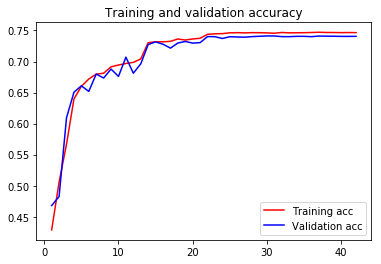

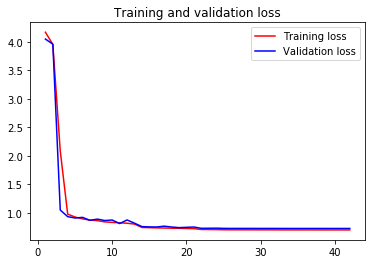

In [96]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [0]:
# get the predictions for the test data
predicted_classes = model.predict_classes(test_features_flat)

In [0]:
# get the indices to be plotted
y_true = df1.iloc[:, 0]
correct = np.nonzero(predicted_classes==y_true)[0]
incorrect = np.nonzero(predicted_classes!=y_true)[0]

In [99]:

target_names = ["Class {}".format(i) for i in range(10)]
print(classification_report(y_true, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.65      0.69      0.67      1000
     Class 1       0.96      0.93      0.94      1000
     Class 2       0.62      0.56      0.59      1000
     Class 3       0.70      0.84      0.76      1000
     Class 4       0.62      0.67      0.64      1000
     Class 5       0.84      0.86      0.85      1000
     Class 6       0.47      0.37      0.42      1000
     Class 7       0.83      0.84      0.83      1000
     Class 8       0.87      0.85      0.86      1000
     Class 9       0.88      0.88      0.88      1000

    accuracy                           0.75     10000
   macro avg       0.74      0.75      0.75     10000
weighted avg       0.74      0.75      0.75     10000



The model lacks precision for class 6, and underperforms for class 0 in reference fo rthe rest of them.


In [100]:
test_features[correct].shape

(7490, 1, 1, 512)

In [0]:

filename = 'Image Classification(VGG16).sav'
pickle.dump(model, open(filename, 'wb'))